In [1]:
import numpy as np 
import pandas as pd
import geopandas as gpd
import itertools
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import cm
from shapely.wkt import loads
# import contextily as ctx
%matplotlib inline

del matplotlib.font_manager.weight_dict['roman']
matplotlib.font_manager._rebuild()
# plt.rcParams[\"font.family\"] = \"Times New Roman\"
font = {'family' : 'Times New Roman', 'weight' : 'normal'}
SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 16
plt.rc('font', **font)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
# matplotlib.rc('text', usetex = True)     ### use latex symbols

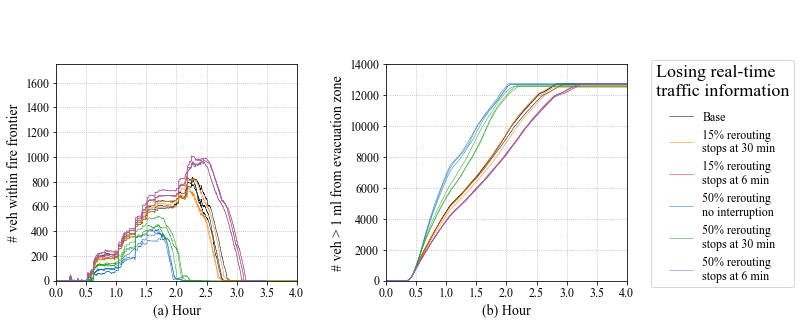

In [64]:
matplotlib.rc('text', usetex = False)
### baseline parameters
b_random_seed=0
b_fire_speed, d_fire_speed = 1, {1: 'Baseline: 1991\nOakland Firestorm', 0.5: r'0.5 $\times$ baseline speed', 2: r'2.0 $\times$ baseline speed'}
b_dept_time_id, d_dept_time_id, d_dept_time_id2 = 'mid', {
    'fst': 'Baseline (fast):\nN(20 min, 10 min)', 
    'mid': 'Medium:\nN(40 min, 20 min)', 
    'slw': 'Slow:\nN(60 min, 30 min)'}, {
    'fst': 'Baseline\ncumulative departure', 
    'mid': 'Medium scenario\ncumulative departure', 
    'slw': 'Slow scenario\ncumulative departure'}
b_tow_pct, d_tow_pct = 0.1, {0: 'Baseline (0%)', 0.1: '10%', 0.25: '25%'}
b_hh_veh, d_hh_veh = 'survey', {'survey': 'Baseline (survey):\n44%/43%/13% hh\nwith 1/2/3 veh', 1: '1 veh/hh', 3: '3 veh/hh'}
b_reroute_pct, d_reroute_pct = 0.15, {0: 'Baseline (0%)', 0.2: '20%', 0.5: '50%', 1: '100%'}
b_phase_tdiff, d_phase_tdiff = 0, {0: 'Baseline (no\nphased evacuation)', 15: '15 min apart', 30: '30 min apart', 60: '60 min apart'}
b_counterflow, d_counterflow = 0, {0: 'Baseline\n(no contraflow)', 1: 'Contraflow short', 2: 'Contraflow long'}
b_reroute_id, d_reroute_id = "0", {"0": "Base", "1": "Routing stops at 1hr", "2": "Routing stops at 2hrs", "0.1": "rerouting stops\nat 6 min", "0.5": "rerouting stops\nat 30 min", "0.17": "rerouting stops at 10min"}

### fire speed
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(pad=5)
fig.suptitle(' ')
color = iter(['k'] + [plt.rcParams['axes.prop_cycle'].by_key()['color'][1], plt.rcParams['axes.prop_cycle'].by_key()['color'][3], plt.rcParams['axes.prop_cycle'].by_key()['color'][0], plt.rcParams['axes.prop_cycle'].by_key()['color'][2], plt.rcParams['axes.prop_cycle'].by_key()['color'][4], plt.rcParams['axes.prop_cycle'].by_key()['color'][5]])

# for fire_speed in [1, 0.5, 2]:
# for dept_time_id in ['fst', 'mid', 'slw']:
# for tow_pct in [0, 0.1, 0.25]:
# for hh_veh in ['survey', 1, 3]:
# for reroute_pct in [0, 0.2, 0.5, 1]:
# for reroute_id in ['0', '0.5', '0.1']:
# for phase_tdiff in [0, 15, 30, 60]:
# for counterflow in [0, 1, 2]:
label_list = iter(['Base', '15% rerouting\nstops at 30 min', '15% rerouting\nstops at 6 min', '50% rerouting\nno interruption', '50% rerouting\nstops at 30 min', '50% rerouting\nstops at 6 min'])
for (reroute_pct, reroute_id) in [(0.15, '0'), (0.15, '0.5'), (0.15, "0.1"), (0.5, "0"), (0.5, '0.5'), (0.5, '0.1')]:
    c = next(color)
    line_label = next(label_list)
    if reroute_pct==0.15 and reroute_id=='0': random_seed_list = [0,5,10]
    elif reroute_pct==0.15 and reroute_id=='0.1': random_seed_list = [0,5,10]
    elif reroute_pct==0.15 and reroute_id=='0.5': random_seed_list = [0,2,10]
    elif reroute_pct==0.5 and reroute_id=='0': random_seed_list = [0,5,10]
    elif reroute_pct==0.5 and reroute_id=='0.1': random_seed_list = [0,5,10]
    elif reroute_pct==0.5 and reroute_id=='0.5': random_seed_list = [3,6,8]
    else: pass
    for random_seed in random_seed_list:
        try:
            if reroute_pct == 0.5 and (reroute_id in ['0', '0.1']):
                file_name = '../projects/berkeley_trb/simulation_outputs/t_stats/t_stats_reroute_stp_rs{}_f{}_dt{}_tow{}_hhv{}_r{}_rs{}_pt{}_cf{}.csv'.format(random_seed, b_fire_speed, b_dept_time_id, b_tow_pct, b_hh_veh, reroute_pct, reroute_id, b_phase_tdiff, b_counterflow)
            else:
                file_name = '../projects/berkeley_trb/simulation_outputs/t_stats/t_stats_link_gps_cnt_rs{}_f{}_dt{}_tow{}_hhv{}_r{}_rs{}_pt{}_cf{}.csv'.format(random_seed, b_fire_speed, b_dept_time_id, b_tow_pct, b_hh_veh, reroute_pct, reroute_id, b_phase_tdiff, b_counterflow)
            res = pd.read_csv(file_name)
            # print(res.head(1))
        except FileNotFoundError:
            print('{} not found'.format(file_name))
            continue
        line,= ax[0].plot(res['t']/3600, res['neg_fdist'], lw=0.5, c=c)
        # line,= ax[0].plot(res['t']/3600, res['avg_fdist'], lw=0.5, c=c)
        if random_seed in [2, 3, 5]:
        #     line.set_label(d_reroute_id[reroute_id])   
            line.set_label(line_label)

        ax[0].set_ylabel('# veh within fire frontier')
        ax[0].set_xlabel('(a) Hour')
        ax[0].set_xlim([0, 4])
        # ax[0].set_xlim([2.5, 3.5])
        ax[0].set_ylim([0, 1750])
#         ax[0].set_ylim([0, 3000])
        ax[0].set_xticks(np.arange(0, 4.5, 0.5))
        # ax[0].set_yticks(np.arange(0, 1800, 250))
        ax[0].grid(ls=':')

        ax[1].plot((res['t']/3600).values.tolist()+[6], (res['out_evac_buffer_cnts']+res['arr']).values.tolist()+[np.max(res['arr'])], lw=0.5, c=c)
#         line2,= ax[1].plot((res['t']/3600).values.tolist(), (12677-res['init']-res['load']).values.tolist(), lw=0.5, c=c, ls='--', dashes=(5, 10))
#         if random_seed == 5:
#             line2.set_label(d_dept_time_id2[dept_time_id])
#         ax[1].set_ylabel('# veh > 1 ml from evacuation zone\nor # veh started evacuation')
        ax[1].set_ylabel('# veh > 1 ml from evacuation zone')
        ax[1].set_xlabel('(b) Hour')
        ax[1].set_xlim([0, 4])
        ax[1].set_ylim([0, 14000])
        # ax[1].set_ylim([0, 20000])
        ax[1].set_xticks(np.arange(0, 4.5, 0.5))
        ax[1].set_yticks(np.arange(0, 15000, 2000))
        ax[1].grid(ls=':')

handles, labels = ax[0].get_legend_handles_labels()
handles2, labels2 = ax[1].get_legend_handles_labels()
leg = plt.legend(handles+handles2, labels+labels2, loc=[1.1,-0.03])
leg.set_title("Losing real-time\ntraffic information", prop = {'size': 18})
leg._legend_box.sep = 12
leg._legend_box.align = "center"
plt.show()

In [79]:
# for counterflow in [0, 1, 2]:
# for fire_speed in [1, 0.5, 2]:
# for reroute_id in ['0', '0.1', '0.5']:
#     if reroute_id=='0': random_seed_list = [0,5,10]
#     elif reroute_id=='0.1': random_seed_list = [0, 5, 10]
#     elif reroute_id=='0.5': random_seed_list = [0,2,10]
#     else: pass
for (reroute_pct, reroute_id) in [(0.15, '0'), (0.15, '0.5'), (0.15, "0.1"), (0.5, "0"), (0.5, '0.5'), (0.5, '0.1')]:
    if reroute_pct==0.15 and reroute_id=='0': random_seed_list = [0,5,10]
    elif reroute_pct==0.15 and reroute_id=='0.1': random_seed_list = [0,5,10]
    elif reroute_pct==0.15 and reroute_id=='0.5': random_seed_list = [0,2,10]
    elif reroute_pct==0.5 and reroute_id=='0': random_seed_list = [0,5,10]
    elif reroute_pct==0.5 and reroute_id=='0.1': random_seed_list = [0,5,10]
    elif reroute_pct==0.5 and reroute_id=='0.5': random_seed_list = [3,6,8]
    else: pass
    res_list = []
    # for random_seed in [0, 5, 10]:
    for random_seed in random_seed_list:
        # file_name = '../projects/berkeley_trb/simulation_outputs/t_stats/t_stats_link_gps_cnt_rs{}_f1_dtmid_tow0.1_hhvsurvey_r0.15_rs{}_pt0_cf0.csv'.format(random_seed, reroute_id)
        if reroute_pct == 0.5 and (reroute_id in ['0', '0.1']):
            file_name = '../projects/berkeley_trb/simulation_outputs/t_stats/t_stats_reroute_stp_rs{}_f1_dtmid_tow0.1_hhvsurvey_r{}_rs{}_pt0_cf0.csv'.format(random_seed, reroute_pct, reroute_id)
        else:
            file_name = '../projects/berkeley_trb/simulation_outputs/t_stats/t_stats_link_gps_cnt_rs{}_f1_dtmid_tow0.1_hhvsurvey_r{}_rs{}_pt0_cf0.csv'.format(random_seed, reroute_pct, reroute_id)
            res = pd.read_csv(file_name)
        res = pd.read_csv(file_name)
        arrival_time = np.min(res.loc[(res['arr'] + res['out_evac_buffer_cnts'])>12500, 't'])
        # res_random_one = np.max(res['neg_fdist'])
        # res_random_one = arrival_time/3600
        res_random_one = np.sum(res['neg_fdist'])/3600
        # res_random_one = np.min(res.loc[res['t']<=arrival_time, 'avg_fdist'])/1609
        # print(res.iloc[3000])
        res_list.append(res_random_one)
    print(res_list, np.mean(res_list))

[946.6058333333333, 1033.4983333333332, 1051.7566666666667] 1010.6202777777777
[917.4083333333333, 1070.8805555555555, 935.0358333333334] 974.4415740740741
[1439.973888888889, 1482.1988888888889, 1367.576111111111] 1429.9162962962964
[257.14944444444444, 281.22777777777776, 318.65] 285.6757407407407
[400.45694444444445, 462.3958333333333, 369.9894444444444] 410.94740740740735
[1439.973888888889, 1482.1988888888889, 1367.576111111111] 1429.9162962962964


In [75]:
(2.1-2.9)/2.9

-0.2758620689655172

In [47]:
file_name = '../projects/berkeley_trb/simulation_outputs/t_stats/t_stats_rs5_f2_dtmid_tow0.1_hhvsurvey_r0.15_pt0_cf0.csv'
res = pd.read_csv(file_name)
res.iloc[3000]

t                       3000.0
init                    2594.0
load                    1682.0
arr                     2869.0
move                     130.0
avg_fdist               1293.7
neg_fdist                481.0
out_evac_zone_cnts      1232.0
out_evac_buffer_cnts     636.0
Name: 3000, dtype: float64